In [2]:
!pip install dmba


   ---------------------------------------- 0.0/11.8 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.8 MB 11.2 MB/s eta 0:00:01
   ----------------------- ---------------- 6.8/11.8 MB 23.3 MB/s eta 0:00:01
   ---------------------------- ----------- 8.4/11.8 MB 16.3 MB/s eta 0:00:01
   ---------------------------------- ----- 10.2/11.8 MB 13.6 MB/s eta 0:00:01
   ---------------------------------------- 11.8/11.8 MB 12.1 MB/s  0:00:01

   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   -------------------- ------------------- 1/2 [dmba]
   -------------------- ------------------- 1/2 [dmba]
   --------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

%matplotlib inline


In [6]:
df=pd.read_excel("Final eda done dataset.xlsx")
df.head()

,state,quarter,housing_price_growth,stringency_index,gdp_growth,average_interest_rate,unemployment_rate,population,deaths_per_million_y,deaths_per_million
0,Alabama,2020Q1,0.780844,15.898242,-0.729693,1.5125,3.2,5024279.0,2.786469,2.786469
1,Alabama,2020Q1,0.780844,15.898242,-0.729693,1.5125,3.3,5024279.0,2.786469,2.786469
2,Alabama,2020Q1,0.780844,15.898242,-0.729693,1.5125,3.4,5024279.0,2.786469,2.786469
3,Alabama,2020Q1,0.646086,15.898242,-0.729693,1.5125,3.2,5024279.0,2.786469,2.786469
4,Alabama,2020Q1,0.646086,15.898242,-0.729693,1.5125,3.3,5024279.0,2.786469,2.786469


In [7]:
df.describe()

,housing_price_growth,stringency_index,gdp_growth,average_interest_rate,unemployment_rate,population,deaths_per_million_y,deaths_per_million
count,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7.344000e+03,7344.000000,7344.000000
mean,0.699979,27.900388,0.672327,0.922277,4.467688,5.704638e+06,216.776658,204.020366
std,0.735119,23.094555,1.501945,0.347637,1.859337,4.567338e+06,169.473755,238.988262
min,-1.357329,0.000000,-2.399116,0.350000,1.700000,5.768510e+05,-23.897864,-23.897864
25%,0.194060,0.000000,-0.093197,0.668750,3.100000,1.839106e+06,108.762781,8.085935
50%,0.628134,23.511522,0.691223,0.850000,3.900000,4.581796e+06,149.706599,119.447209
75%,1.228320,45.732698,1.444082,1.112500,5.300000,7.705281e+06,293.956144,293.956144
max,2.779709,88.632198,3.750001,1.778125,8.600000,1.650454e+07,571.746188,1589.838469


In [21]:
# normalizing the dataset
# Outcome variable
outcome = "housing_price_growth"

# Identify NON-numeric columns to exclude
excludeColumns = ["housing_price_growth", "state", "quarter"]

# Create list of predictors = all columns except excluded ones
predictors = [c for c in df.columns if c not in excludeColumns]

# Initialize scaler
scaler = MinMaxScaler()

# Make a copy of dataset
df_scaled = df.copy()

# Fit + transform ONLY predictor columns
df_scaled[predictors] = scaler.fit_transform(df[predictors])

print("Normalized dataset:")
df_scaled.head()

Normalized dataset:


,state,quarter,housing_price_growth,stringency_index,gdp_growth,average_interest_rate,unemployment_rate,population,deaths_per_million_y,deaths_per_million
0,Alabama,2020Q1,0.780844,0.179373,0.271490,0.814004,0.217391,0.279226,0.044799,0.016536
1,Alabama,2020Q1,0.780844,0.179373,0.271490,0.814004,0.231884,0.279226,0.044799,0.016536
2,Alabama,2020Q1,0.780844,0.179373,0.271490,0.814004,0.246377,0.279226,0.044799,0.016536
3,Alabama,2020Q1,0.646086,0.179373,0.271490,0.814004,0.217391,0.279226,0.044799,0.016536
4,Alabama,2020Q1,0.646086,0.179373,0.271490,0.814004,0.231884,0.279226,0.044799,0.016536


In [22]:
# create a list of predictor variables (everything except target + non-numeric stuff)
excludeColumns = ["housing_price_growth", "state", "quarter", "deaths_per_million"]

predictors = [c for c in df.columns if c not in excludeColumns]
outcome = "housing_price_growth"

# Split X and Y from the *scaled* dataset
X = df_scaled[predictors]   # ✅ use scaled version
y = df_scaled[outcome]      # optional (target normalization not required)

# Train-validation split
train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.4, random_state=1
)

# Train the regression model
reg = LinearRegression()
reg.fit(train_X, train_y)


LinearRegression()

In [23]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
print('intercept', reg.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': reg.coef_}))

# Prediction
y_valid_pred = reg.predict(valid_X)
y_train_pred = reg.predict(train_X)


intercept 0.33483557464280167
               Predictor  coefficient
0       stringency_index     1.359602
1             gdp_growth     0.085617
2  average_interest_rate    -0.521945
3      unemployment_rate    -0.529138
4             population     0.209951
5   deaths_per_million_y     0.617931


# Training Part evaluation


In [27]:
from sklearn.metrics import mean_squared_error


# Mean Squared Error
mse = mean_squared_error(train_y, y_train_pred)

# Root Mean Squared Error (take square root manually)
rmse = np.sqrt(mse)

print("Mean Squared Error:", round(mse, 2))
print("Root Mean Squared Error:", round(rmse, 2))


Mean Squared Error: 0.42
Root Mean Squared Error: 0.65


In [26]:
regressionSummary(train_y,reg.predict(train_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.6467
            Mean Absolute Error (MAE) : 0.5055
          Mean Percentage Error (MPE) : -50.2309
Mean Absolute Percentage Error (MAPE) : 273.2797


# Validation Part Evaluation

In [28]:
from sklearn.metrics import mean_squared_error


# Mean Squared Error
mse = mean_squared_error(valid_y, y_valid_pred)

# Root Mean Squared Error (take square root manually)
rmse = np.sqrt(mse)

print("Mean Squared Error:", round(mse, 2))
print("Root Mean Squared Error:", round(rmse, 2))

Mean Squared Error: 0.42
Root Mean Squared Error: 0.65


In [30]:
regressionSummary(valid_y, reg.predict(valid_X))



Regression statistics

                      Mean Error (ME) : -0.0037
       Root Mean Squared Error (RMSE) : 0.6491
            Mean Absolute Error (MAE) : 0.5101
          Mean Percentage Error (MPE) : -22.9936
Mean Absolute Percentage Error (MAPE) : 251.8969


In [32]:
# Calculate R2
from sklearn.metrics import r2_score

r2 = r2_score(train_y, y_train_pred)
p = len(predictors)
n = len(train_y)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("R2:", round(r2, 2))
print("Adjusted R2:", round(adjusted_r2, 2))


R2: 0.23
Adjusted R2: 0.23


In [34]:
# Calculating AIC and BIC
print("adjusted r2:", round(adjusted_r2_score(train_y, y_train_pred, reg), 2))
print("AIC:", round(AIC_score(train_y, y_train_pred, reg), 2))
print("BIC:", round(BIC_score(train_y, y_train_pred, reg), 2))


adjusted r2: 0.23
AIC: 8679.06
BIC: 8730.18


In [35]:
# Use predict() to make prediction on a new set (validation set, for example)
reg_pred = reg.predict(valid_X)

result = pd.DataFrame({
    'Predicted': reg_pred,
    'Actual': valid_y,
    'Residual': valid_y - reg_pred
})

print(result.head(20))

# Compute also common accuracy metrics
regressionSummary(valid_y, reg_pred)


      Predicted    Actual  Residual
4385   0.496016  0.362769 -0.133247
2532   0.718557  1.136727  0.418170
1936   0.790132  0.071390 -0.718742
2338   1.425992  0.883482 -0.542511
4261   0.682711  2.149255  1.466544
1392   0.832116  0.097082 -0.735035
4247   1.149549  0.530657 -0.618891
3791   1.050223  2.637037  1.586813
3872   0.461939  0.791857  0.329919
6913   0.006927  0.051528  0.044602
4848   0.683753 -0.109711 -0.793464
5676   0.525593  0.089443 -0.436150
6083   1.326167  1.302772 -0.023395
1882   1.213344  0.412486 -0.800858
3244   1.138311  1.548978  0.410668
4987   0.796822  0.460840 -0.335982
2878   0.296791  0.216868 -0.079922
2537   0.718557  1.159571  0.441013
7157   0.742698 -0.214334 -0.957032
2378   1.047417  1.209609  0.162192

Regression statistics

                      Mean Error (ME) : -0.0037
       Root Mean Squared Error (RMSE) : 0.6491
            Mean Absolute Error (MAE) : 0.5101
          Mean Percentage Error (MPE) : -22.9936
Mean Absolute Percentage Erro

# Backward elimination using OLS technique

In [40]:
def backward_elimination(variables, train_model, score_model):
    variables = list(variables)     # make a copy
    print("Variables:", ", ".join(variables))

    model = train_model(variables)
    best_score = score_model(model, variables)
    print(f"Start: score={best_score:.2f}")

    improved = True

    while improved and len(variables) > 1:
        improved = False
        scores = []

        # try removing EACH variable once
        for v in variables:
            trial_vars = [x for x in variables if x != v]
            model_trial = train_model(trial_vars)
            score_trial = score_model(model_trial, trial_vars)
            scores.append((score_trial, v, trial_vars))

        # pick the *best* (lowest) AIC score
        scores.sort()
        best_trial_score, removed_var, best_trial_vars = scores[0]

        # if removing improves score → remove it
        if best_trial_score < best_score:
            print(f"Step: score={best_trial_score:.2f}, remove {removed_var}")
            variables = best_trial_vars
            best_score = best_trial_score
            improved = True
        else:
            print(f"Step: score={best_score:.2f}, remove None")

    return variables


In [41]:
best_variables = backward_elimination(train_X.columns, train_model, score_model)
print("\nFinal variables:", best_variables)


Variables: stringency_index, gdp_growth, average_interest_rate, unemployment_rate, population, deaths_per_million_y
Start: score=8679.06
Step: score=8679.06, remove None

Final variables: ['stringency_index', 'gdp_growth', 'average_interest_rate', 'unemployment_rate', 'population', 'deaths_per_million_y']


In [42]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))



Regression statistics

                      Mean Error (ME) : -0.0037
       Root Mean Squared Error (RMSE) : 0.6491
            Mean Absolute Error (MAE) : 0.5101
          Mean Percentage Error (MPE) : -22.9936
Mean Absolute Percentage Error (MAPE) : 251.8969


# Forward selection model 

In [45]:
def forward_selection(variables, train_model, score_model, verbose=False):

    selected = []      # variables selected so far
    remaining = list(variables)  # variables we haven't tried yet
    current_score = float("inf")

    if verbose:
        print("Variables:", ", ".join(remaining))
        print(f"Start: score={current_score}, constant")

    while remaining:

        scores = []

        for v in remaining:
            trial_vars = selected + [v]
            model_trial = train_model(trial_vars)
            score_trial = score_model(model_trial, trial_vars)
            scores.append((score_trial, v))

        # sort results so best (lowest AIC) is first
        scores.sort()

        # SAFETY CHECK — if no score improved, stop
        best_score_trial, added_var = scores[0]

        if best_score_trial < current_score:
            selected.append(added_var)
            remaining.remove(added_var)
            current_score = best_score_trial

            if verbose:
                print(f"Step: score={current_score:.2f}, add {added_var}")

        else:
            if verbose:
                print(f"Step: score={current_score:.2f}, add None")
            break

    return selected
    


In [46]:
best_vars = forward_selection(train_X.columns, train_model, score_model, verbose=True)
print("Final variables:", best_vars)


Variables: stringency_index, gdp_growth, average_interest_rate, unemployment_rate, population, deaths_per_million_y
Start: score=inf, constant
Step: score=9235.16, add deaths_per_million_y
Step: score=8959.17, add stringency_index
Step: score=8765.19, add average_interest_rate
Step: score=8714.33, add unemployment_rate
Step: score=8681.64, add population
Step: score=8679.06, add gdp_growth
Final variables: ['deaths_per_million_y', 'stringency_index', 'average_interest_rate', 'unemployment_rate', 'population', 'gdp_growth']


In [49]:
# Join X + y
train_df = train_X.join(train_y)

# predictors = best_vars (if you're using variable selection)
predictors = train_X.columns

# Build formula string
formula = 'housing_price_growth ~ ' + ' + '.join(predictors)

# Correct import for OLS
import statsmodels.formula.api as smf

# Fit the model
reg = smf.ols(formula=formula, data=train_df).fit()

# Print OLS summary
print(reg.summary())


                             OLS Regression Results                             
Dep. Variable:     housing_price_growth   R-squared:                       0.226
Model:                              OLS   Adj. R-squared:                  0.225
Method:                   Least Squares   F-statistic:                     214.2
Date:                  Sun, 23 Nov 2025   Prob (F-statistic):          1.76e-240
Time:                          20:11:41   Log-Likelihood:                -4331.5
No. Observations:                  4406   AIC:                             8677.
Df Residuals:                      4399   BIC:                             8722.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept 

# Visualizations

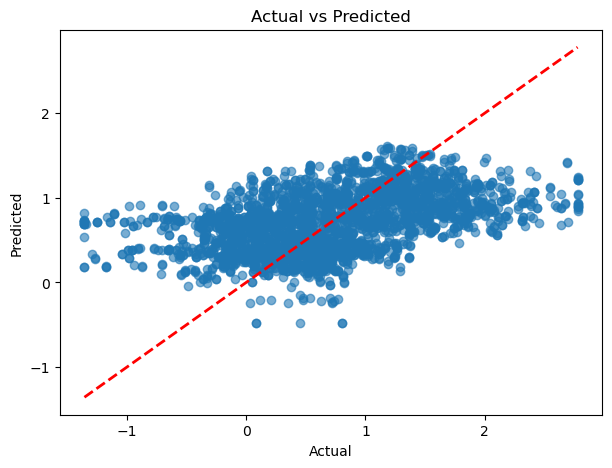

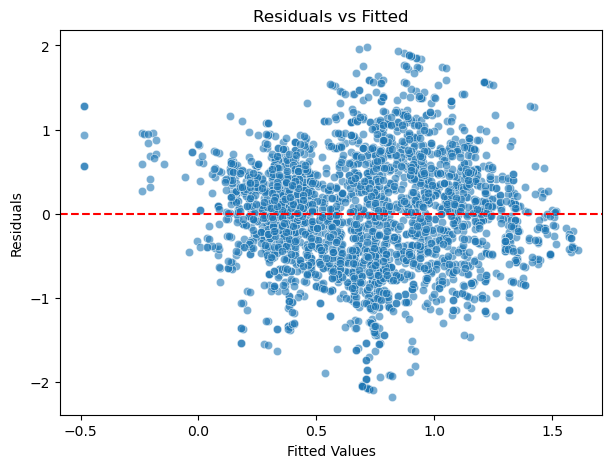

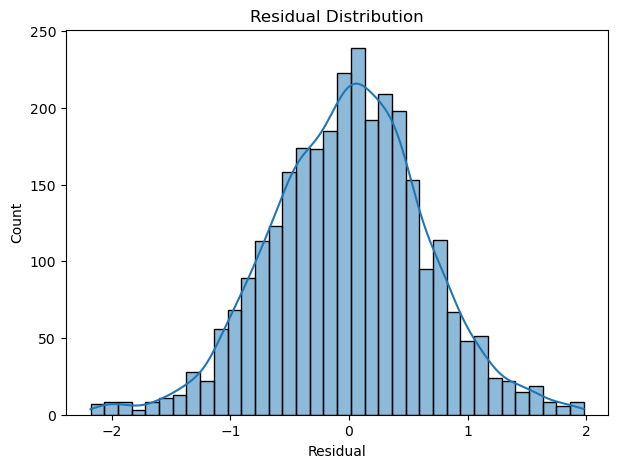

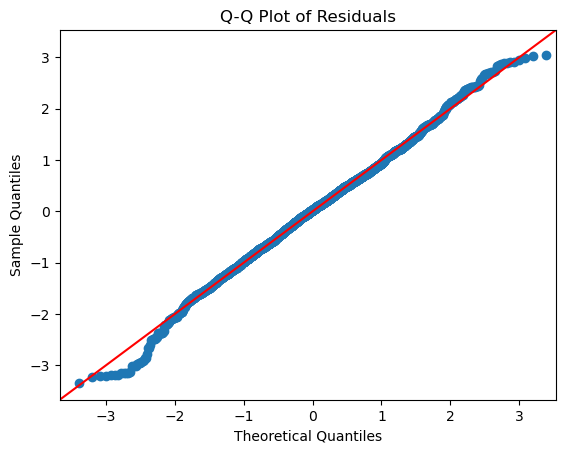

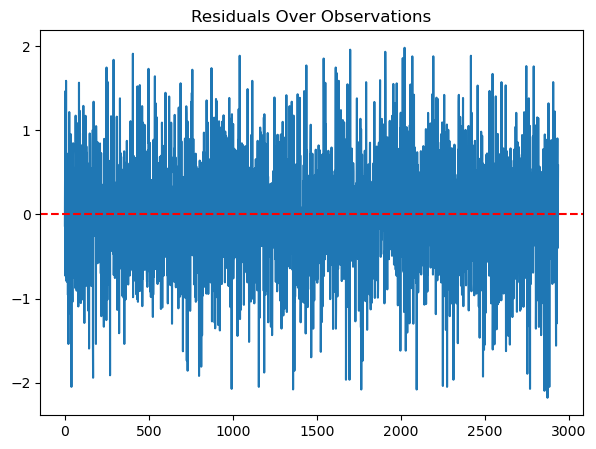

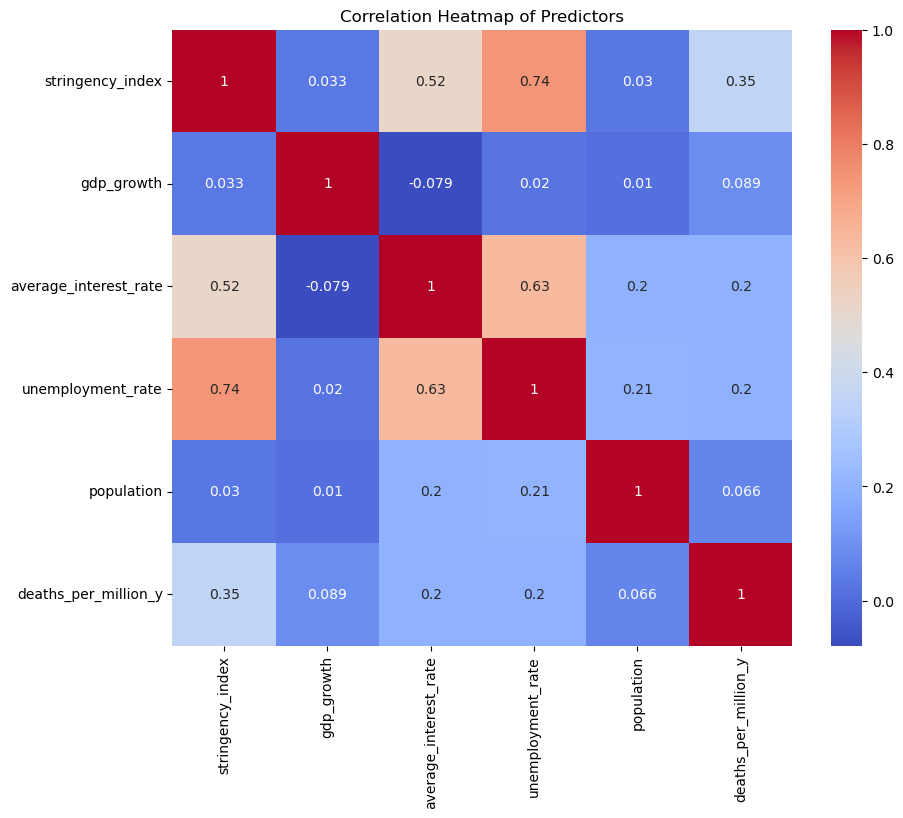

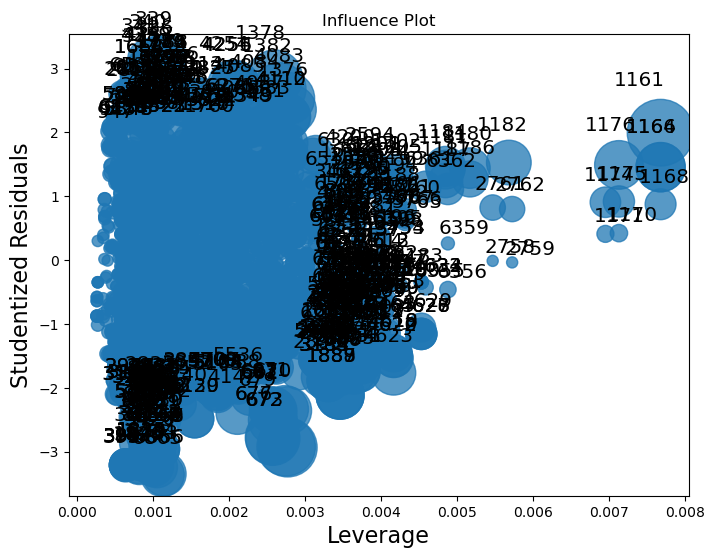

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# ----- 1. Actual vs Predicted -----

plt.figure(figsize=(7,5))
plt.scatter(valid_y, reg.predict(valid_X), alpha=0.6)
plt.plot([valid_y.min(), valid_y.max()],
         [valid_y.min(), valid_y.max()],
         'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

# ----- 2. Residuals vs Fitted -----

residuals = valid_y - reg.predict(valid_X)

plt.figure(figsize=(7,5))
sns.scatterplot(x=reg.predict(valid_X), y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# ----- 3. Histogram of Residuals -----

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.show()

# ----- 4. Q-Q Plot -----

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

# ----- 5. Residuals Over Index (optional) -----

plt.figure(figsize=(7,5))
plt.plot(residuals.values)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Observations")
plt.show()

# ----- 6. Correlation Heatmap -----

plt.figure(figsize=(10,8))
sns.heatmap(train_X.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Predictors")
plt.show()

# ----- 7. Influence Plot -----

fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.influence_plot(reg, ax=ax, criterion="cooks")
plt.title("Influence Plot")
plt.show()
